In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'TON'
yf_crypto = 'TON11419'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [5]:
# Retreive max data
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2021-08-27,0.519893,0.687477,0.498175,0.686748,573566
2021-08-28,0.686766,0.691065,0.606474,0.640526,250158
2021-08-29,0.640724,0.648018,0.527709,0.548201,188295
2021-08-30,0.548234,0.915924,0.547050,0.868268,763243
2021-08-31,0.869410,1.132030,0.795093,1.034563,1802341


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-04,6.814379,7.311724,6.730777,7.311724,355355808
2024-06-05,7.311724,7.775840,7.132280,7.196506,512581200
2024-06-06,7.196506,7.540531,7.129691,7.535858,306885619
2024-06-07,7.535842,7.739530,6.857299,7.212680,503389719
2024-06-08,7.212330,7.427956,6.998873,7.032557,257312227


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

7.032557010650635

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.993244,0.996614,0.993641,0.751510
High,0.993244,1.000000,0.991365,0.996558,0.766221
Low,0.996614,0.991365,1.000000,0.995615,0.739713
Close,0.993641,0.996558,0.995615,1.000000,0.756653
Volume,0.751510,0.766221,0.739713,0.756653,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2021-08-27,0.686748,573566
2021-08-28,0.640526,250158
2021-08-29,0.548201,188295
2021-08-30,0.868268,763243
2021-08-31,1.034563,1802341
...,...,...
2024-06-04,7.311724,355355808
2024-06-05,7.196506,512581200
2024-06-06,7.535858,306885619


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2021-10-15,0.751013,179246,0.756689,0.739355,0.790405
2021-10-16,0.789881,553665,0.758278,0.738912,0.792468
2021-10-17,0.764882,303745,0.762220,0.738816,0.794955
2021-10-18,0.765021,206167,0.766315,0.740584,0.799291
2021-10-19,0.705716,639782,0.754609,0.741231,0.796040


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-06-04,7.311724,355355808,6.570269,6.507652,6.185064
2024-06-05,7.196506,512581200,6.659065,6.554816,6.202157
2024-06-06,7.535858,306885619,6.773431,6.616785,6.231193
2024-06-07,7.212680,503389719,6.848366,6.665106,6.245259
2024-06-08,7.032557,257312227,6.902379,6.686223,6.264379


<Axes: xlabel='Date'>

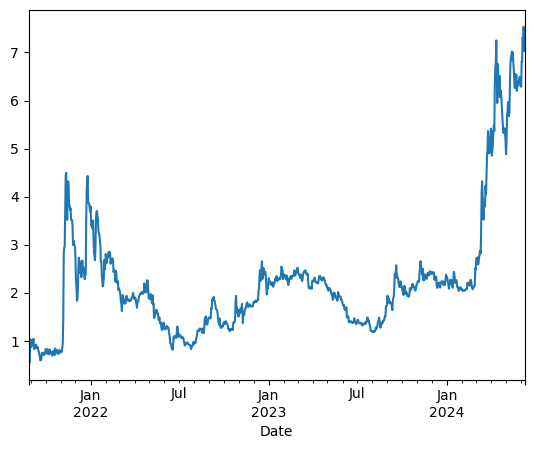

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2021-08-27,0.686748,573566
1,2021-08-28,0.640526,250158
2,2021-08-29,0.548201,188295
3,2021-08-30,0.868268,763243
4,2021-08-31,1.034563,1802341
...,...,...,...
1012,2024-06-04,7.311724,355355808
1013,2024-06-05,7.196506,512581200
1014,2024-06-06,7.535858,306885619
1015,2024-06-07,7.212680,503389719


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

17:02:28 - cmdstanpy - INFO - Chain [1] start processing
17:02:28 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
1102,2024-09-02
1103,2024-09-03
1104,2024-09-04
1105,2024-09-05
1106,2024-09-06


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1077,2024-08-08,8.359029,7.392138,8.702871,8.122842,8.615796,-0.345594,-0.345594,-0.345594,0.001352,0.001352,0.001352,-0.346946,-0.346946,-0.346946,0.0,0.0,0.0,8.013434
1078,2024-08-09,8.386116,7.444714,8.634412,8.141557,8.651223,-0.336832,-0.336832,-0.336832,-0.001084,-0.001084,-0.001084,-0.335747,-0.335747,-0.335747,0.0,0.0,0.0,8.049285
1079,2024-08-10,8.413204,7.471366,8.750619,8.154758,8.683146,-0.331298,-0.331298,-0.331298,-0.009020,-0.009020,-0.009020,-0.322278,-0.322278,-0.322278,0.0,0.0,0.0,8.081906
1080,2024-08-11,8.440292,7.539053,8.736093,8.176064,8.717983,-0.306739,-0.306739,-0.306739,-0.000394,-0.000394,-0.000394,-0.306345,-0.306345,-0.306345,0.0,0.0,0.0,8.133553
1081,2024-08-12,8.467380,7.562618,8.854023,8.197493,8.752713,-0.293259,-0.293259,-0.293259,-0.005467,-0.005467,-0.005467,-0.287792,-0.287792,-0.287792,0.0,0.0,0.0,8.174122
1082,2024-08-13,8.494468,7.634842,8.905368,8.217776,8.785447,-0.258483,-0.258483,-0.258483,0.008024,0.008024,0.008024,-0.266507,-0.266507,-0.266507,0.0,0.0,0.0,8.235985
1083,2024-08-14,8.521556,7.656419,8.937949,8.239711,8.818095,-0.235836,-0.235836,-0.235836,0.006590,0.006590,0.006590,-0.242426,-0.242426,-0.242426,0.0,0.0,0.0,8.285720
1084,2024-08-15,8.548644,7.703318,9.012141,8.261221,8.853330,-0.214190,-0.214190,-0.214190,0.001352,0.001352,0.001352,-0.215542,-0.215542,-0.215542,0.0,0.0,0.0,8.334454
1085,2024-08-16,8.575732,7.738416,9.055751,8.282791,8.882509,-0.186986,-0.186986,-0.186986,-0.001084,-0.001084,-0.001084,-0.185902,-0.185902,-0.185902,0.0,0.0,0.0,8.388746
1086,2024-08-17,8.602820,7.809671,9.131545,8.304360,8.915425,-0.162634,-0.162634,-0.162634,-0.009020,-0.009020,-0.009020,-0.153614,-0.153614,-0.153614,0.0,0.0,0.0,8.440186


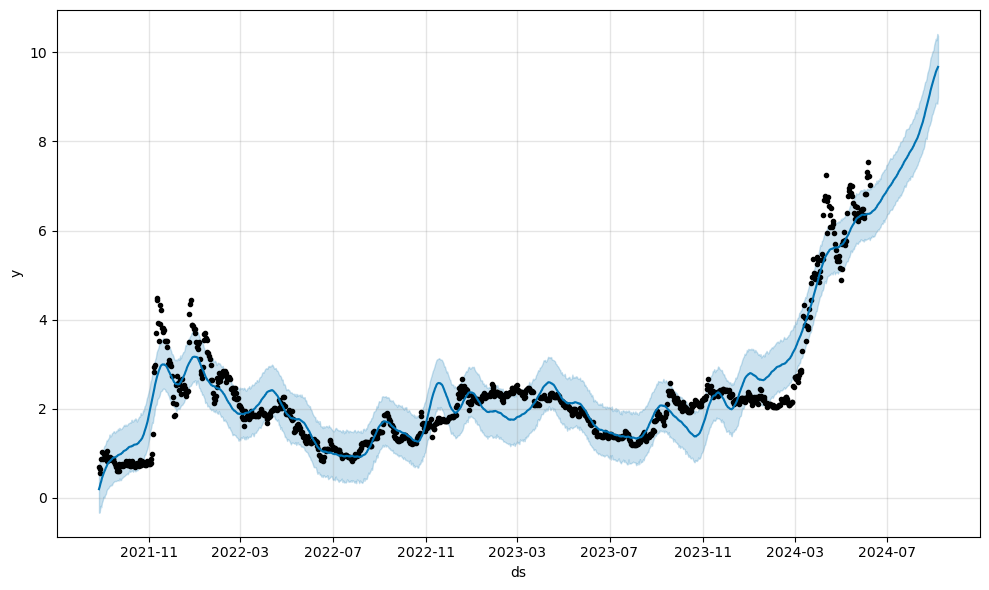

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-09,6.392904,5.841771,6.929497
2024-06-10,6.398395,5.838684,6.960970
2024-06-11,6.424334,5.884542,7.003745
2024-06-12,6.437266,5.858343,6.992693
2024-06-13,6.448300,5.865791,6.979834
...,...,...,...
2024-09-02,9.487462,8.785126,10.234392
2024-09-03,9.551298,8.863620,10.304126
2024-09-04,9.596564,8.862743,10.269008


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

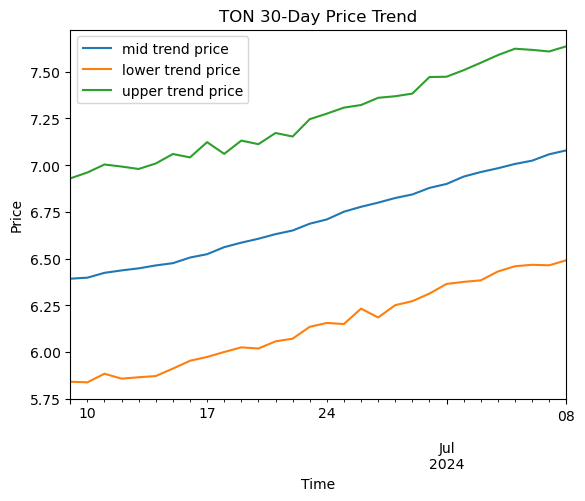

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

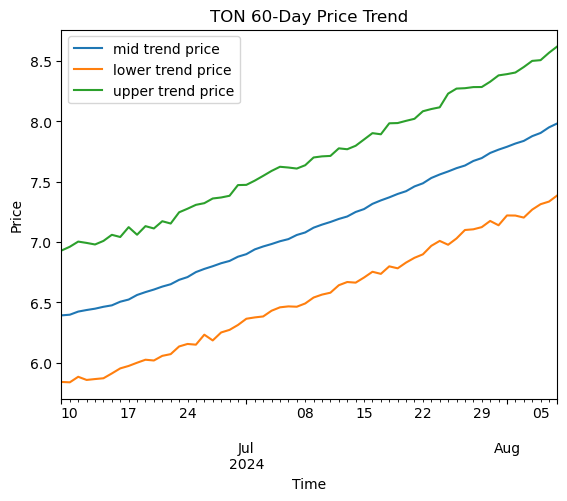

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

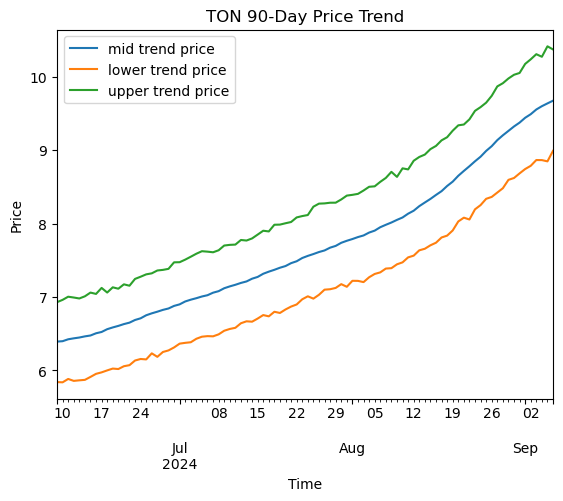

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')   
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

7.032557010650635

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

6.3929039814505515

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

6.712730496050593

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

6.389996079358673

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

7.119560063143698

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

8.027062588298232

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

9.674214602997235

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

0.061

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

0.196

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.441

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

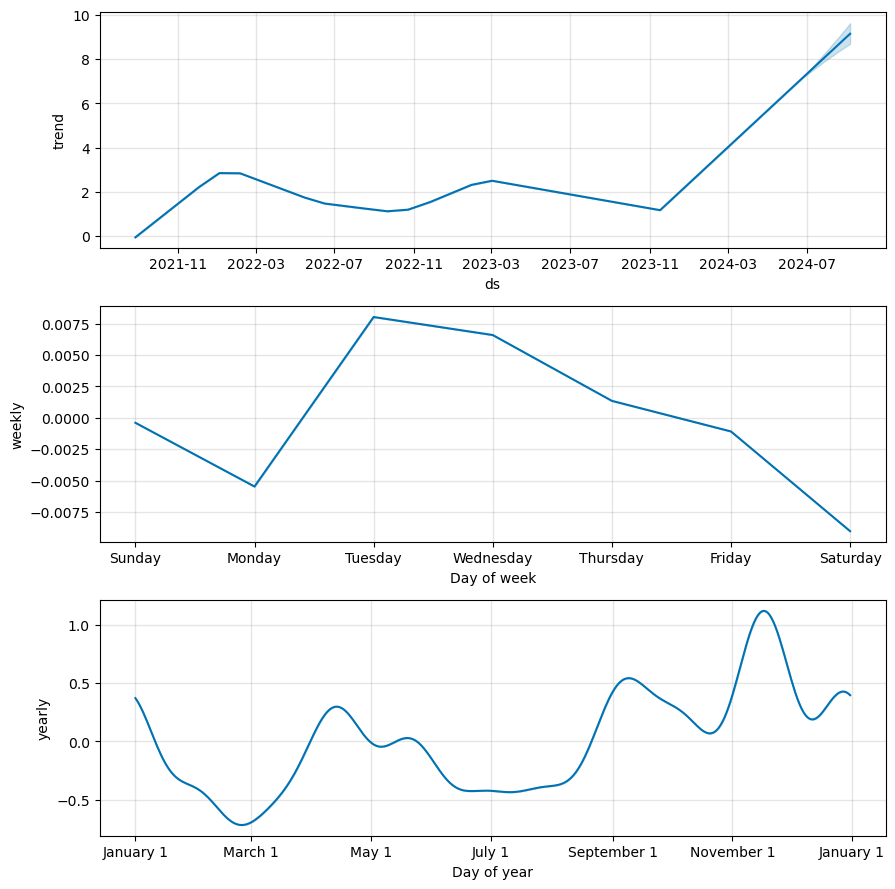

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

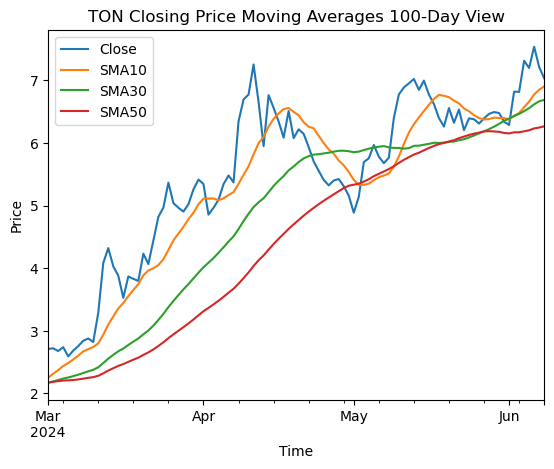

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

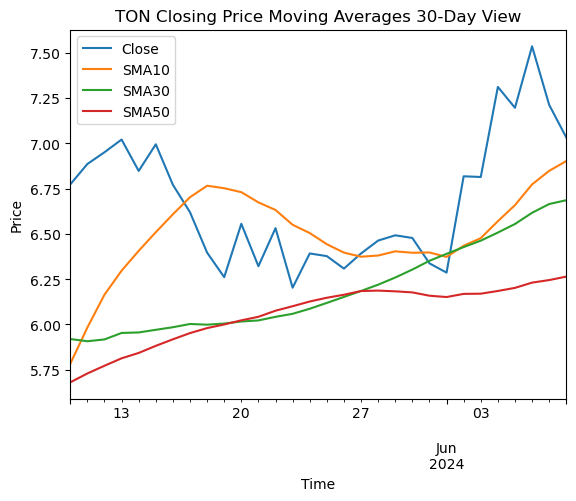

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-09
File created :  2024-06-09.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.43657100200653076,-0.07364667494769794,-0.0009456964793739253,0.3544596118546628
ADA,0.43657100200653076,-0.08437373181845453,0.002834181787628731,0.36173019111251126
ADA,0.43657100200653076,-0.08372637062435029,0.0025919668069758206,0.3631142967037635
ADA,0.43657100200653076,-0.0783190338427533,0.004381382002310641,0.36321329122708335
ATOM,7.759523868560791,-0.2525451407294217,-0.22995154564524733,0.08676291965413196
AVAX,32.29003143310547,-0.06238204683353343,0.016250905637703372,0.184324988794629
AVAX,32.29003143310547,-0.061383912293528464,0.006255814491331391,0.188757389641659
BNB,682.6651611328125,-0.25945675235825627,-0.21619087415535265,-0.19462572272913758
BONK,2.700000004551839e-05,0.19694570130627698,0.3277996886564134,0.4415377509818921
BTC,69305.7734375,-0.1351637782567381,-0.09261706566887273,-0.09372540555309616
DOGE,0.14605900645256042,-0.18446710000937716,-0.08920949588743987,-0.03966410323402325
ETH,3680.949951171875,-0.11161221692021561,-0.03134563847923688,-0.